In [6]:
import timeit
import numpy as np
import pandas as pd
import tensorflow as tf
import category_encoders as ce
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score, ConfusionMatrixDisplay, classification_report
from sklearn.linear_model import SGDClassifier
pd.set_option('display.max_columns', None)

In [7]:
def load_data(nrows=100_000):
    chunksize = 10 ** 6
    filename="../input/avazu-ctr-prediction/train.gz"
    chunks = []
    with pd.read_csv(filename, chunksize=chunksize, compression='gzip', nrows=nrows) as reader:
        for chunk in reader:
            chunks.append(chunk)
    data = pd.concat(chunks)

    return data

In [8]:
def find_best_estimator(params, clf, X, Y, verbose=0):
    grid_search = GridSearchCV(clf, params, n_jobs=-1, cv=3, scoring='roc_auc')
    if verbose:
        grid_search.fit(X, Y, verbose=100)
    else:
        grid_search.fit(X, Y)
    print(grid_search.best_params_)
    return grid_search.best_estimator_

In [9]:
nrows_data = 300_000
data = load_data(nrows=nrows_data)

In [10]:
data.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1.000009e+18,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,ddd2926e,44956a24,1,2,15706,320,50,1722,0,35,-1,79
1,1.000017e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,96809ac8,711ee120,1,0,15704,320,50,1722,0,35,100084,79
2,1.000037e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,b3cf8def,8a4875bd,1,0,15704,320,50,1722,0,35,100084,79
3,1.000064e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,e8275b8f,6332421a,1,0,15706,320,50,1722,0,35,100084,79
4,1.000068e+19,0,14102100,1005,1,fe8cc448,9166c161,0569f928,ecad2386,7801e8d9,07d7df22,a99f214a,9644d0bf,779d90c2,1,0,18993,320,50,2161,0,35,-1,157


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                300000 non-null  float64
 1   click             300000 non-null  int64  
 2   hour              300000 non-null  int64  
 3   C1                300000 non-null  int64  
 4   banner_pos        300000 non-null  int64  
 5   site_id           300000 non-null  object 
 6   site_domain       300000 non-null  object 
 7   site_category     300000 non-null  object 
 8   app_id            300000 non-null  object 
 9   app_domain        300000 non-null  object 
 10  app_category      300000 non-null  object 
 11  device_id         300000 non-null  object 
 12  device_ip         300000 non-null  object 
 13  device_model      300000 non-null  object 
 14  device_type       300000 non-null  int64  
 15  device_conn_type  300000 non-null  int64  
 16  C14               30

In [12]:
data.describe()

,id,click,hour,C1,banner_pos,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
count,3.000000e+05,300000.000000,3.000000e+05,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000
mean,9.437755e+18,0.170703,1.410210e+07,1005.018653,0.212370,1.040773,0.207820,17953.153303,318.655320,56.938080,1999.884023,0.960367,171.130993,40726.725377,80.463557
std,5.109816e+18,0.376250,6.918111e-01,0.983261,0.421888,0.522933,0.648361,3282.893095,16.746294,37.113841,405.596819,1.261270,264.898631,49173.267507,43.553295
min,9.984920e+12,0.000000,1.410210e+07,1001.000000,0.000000,0.000000,0.000000,375.000000,120.000000,20.000000,112.000000,0.000000,33.000000,-1.000000,13.000000
25%,5.088626e+18,0.000000,1.410210e+07,1005.000000,0.000000,1.000000,0.000000,15705.000000,320.000000,50.000000,1722.000000,0.000000,35.000000,-1.000000,48.000000
50%,1.026470e+19,0.000000,1.410210e+07,1005.000000,0.000000,1.000000,0.000000,18936.000000,320.000000,50.000000,2039.000000,0.000000,35.000000,-1.000000,79.000000
75%,1.325013e+19,0.000000,1.410210e+07,1005.000000,0.000000,1.000000,0.000000,20508.000000,320.000000,50.000000,2333.000000,2.000000,171.000000,100083.000000,79.000000
max,1.844670e+19,1.000000,1.410210e+07,1010.000000,7.000000,5.000000,5.000000,21705.000000,728.000000,480.000000,2497.000000,3.000000,1835.000000,100248.000000,195.000000


In [13]:
X = data.drop(columns=['id', 'click', 'hour', 'device_id', 'device_ip'])
Y = data['click']

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

In [15]:
enc = OneHotEncoder(handle_unknown='ignore')
X_train_enc = enc.fit_transform(X_train)
X_test_enc = enc.transform(X_test)

In [16]:
sgdc_clf = SGDClassifier(loss='log_loss', penalty=None, fit_intercept=True, max_iter=100, learning_rate='constant', eta0=0.01)

In [17]:
sgdc_clf.fit(X_train_enc, Y_train)
pos_prob = sgdc_clf.predict_proba(X_test_enc)[:, 1]
print(f"Area under curve ROC for testing dataset is: {roc_auc_score(Y_test, pos_prob)}")

Pole pod krzywą ROC dla zbioru testowego wynosi: 0.7438442051958237


In [18]:
print(classification_report(Y_test, sgdc_clf.predict(X_test_enc), target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.84      0.99      0.91     24949
           1       0.58      0.09      0.16      5051

    accuracy                           0.84     30000
   macro avg       0.71      0.54      0.53     30000
weighted avg       0.80      0.84      0.78     30000



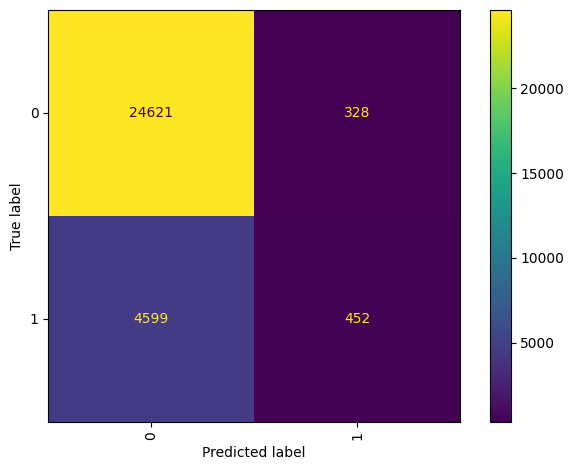

In [19]:
ConfusionMatrixDisplay.from_estimator(
    sgdc_clf, X_test_enc, Y_test, display_labels=['0', '1'], xticks_rotation="vertical"
)
plt.tight_layout()
plt.show()

Penalty, eta0, alpha

In [20]:
sgdc_params = {'penalty': ['l2', 'l1', 'elasticnet', None],
               'eta0': [0.001, 0.01, 1.0],
               'alpha': [0.01, 0.1, 1.0]}

In [21]:
grid_search = GridSearchCV(sgdc_clf, sgdc_params, n_jobs=-1, cv=3, scoring='roc_auc')
grid_search.fit(X_train_enc, Y_train)
print(grid_search.best_params_)
sgdc_best = grid_search.best_estimator_

{'alpha': 1.0, 'eta0': 0.01, 'penalty': None}


In [22]:
pos_prob = sgdc_best.predict_proba(X_test_enc)[:, 1]
print(f"Area under curve ROC for testing dataset is: {roc_auc_score(Y_test, pos_prob)}")

Pole pod krzywą ROC dla zbioru testowego wynosi: 0.7447882018260034


In [23]:
print(classification_report(Y_test, sgdc_best.predict(X_test_enc), target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.85      0.98      0.91     24949
           1       0.52      0.13      0.21      5051

    accuracy                           0.83     30000
   macro avg       0.69      0.55      0.56     30000
weighted avg       0.79      0.83      0.79     30000



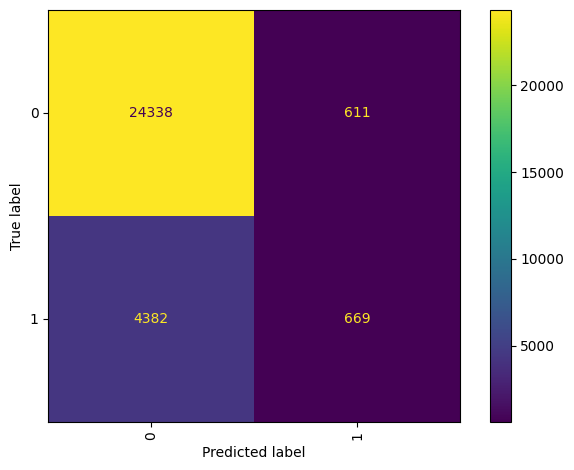

In [24]:
ConfusionMatrixDisplay.from_estimator(
    sgdc_best, X_test_enc, Y_test, display_labels=['0', '1'], xticks_rotation="vertical"
)
plt.tight_layout()
plt.show()

# Online learning

10 000 000 samples

In [25]:
big_data = load_data(10_000_000)

In [26]:
big_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000000 entries, 0 to 9999999
Data columns (total 24 columns):
 #   Column            Dtype  
---  ------            -----  
 0   id                float64
 1   click             int64  
 2   hour              int64  
 3   C1                int64  
 4   banner_pos        int64  
 5   site_id           object 
 6   site_domain       object 
 7   site_category     object 
 8   app_id            object 
 9   app_domain        object 
 10  app_category      object 
 11  device_id         object 
 12  device_ip         object 
 13  device_model      object 
 14  device_type       int64  
 15  device_conn_type  int64  
 16  C14               int64  
 17  C15               int64  
 18  C16               int64  
 19  C17               int64  
 20  C18               int64  
 21  C19               int64  
 22  C20               int64  
 23  C21               int64  
dtypes: float64(1), int64(14), object(9)
memory usage: 1.8+ GB


In [27]:
big_X = big_data.drop(columns=['id', 'click', 'hour', 'device_id', 'device_ip'])
big_Y = big_data['click']

In [28]:
big_X_train, big_X_test, big_Y_train, big_Y_test = train_test_split(big_X, big_Y, test_size=0.1, random_state=42)

In [29]:
big_enc = OneHotEncoder(handle_unknown='ignore')
big_enc.fit(big_X_train)

OneHotEncoder(handle_unknown='ignore')

In [30]:
sgdc_lr_online = SGDClassifier(
    loss='log_loss',
    fit_intercept=True,
    max_iter=100,
    learning_rate='constant',
    **grid_search.best_params_)

In [31]:
start_time = timeit.default_timer()
for i in range(9):
    x_train = big_X_train[i*1_000_000:(i+1)*1_000_000]
    y_train = big_Y_train[i*1_000_000:(i+1)*1_000_000]    
    x_train_enc = big_enc.transform(x_train)
    sgdc_lr_online.partial_fit(x_train_enc, y_train, classes=[0,1])
print(timeit.default_timer()-start_time)

41.16876758600006


In [32]:
big_pos_prob = sgdc_lr_online.predict_proba(big_enc.transform(big_X_test))[:, 1]
print(f"Area under curve ROC for testing dataset is: {roc_auc_score(big_Y_test, big_pos_prob)}")

Pole pod krzywą ROC dla zbioru testowego wynosi: 0.7462095896308881


If we want to work still in the same notebook, we must clear memmory. Otherwise "Your notebook tried to allocate more memory than is available. It has restarted." message will occour

In [33]:
big_data = big_data.iloc[0:0]
big_X, big_Y = big_data.iloc[0:0], big_data.iloc[0:0]
big_X_train, big_X_test, big_Y_train, big_Y_test = big_data.iloc[0:0], big_data.iloc[0:0], big_data.iloc[0:0], big_data.iloc[0:0]
x_train, y_train, x_train_enc = big_data.iloc[0:0], big_data.iloc[0:0], big_data.iloc[0:0]

# Logistic Regression with TensorFlow

In [34]:
X_train_enc.shape 

(270000, 8385)

In [35]:
X_train.nunique()

C1                     6
banner_pos             6
site_id             1422
site_domain         1298
site_category         21
app_id              1211
app_domain            84
app_category          19
device_model        3423
device_type            4
device_conn_type       4
C14                  503
C15                    5
C16                    6
C17                  146
C18                    4
C19                   40
C20                  150
C21                   33
dtype: int64

While shape of X_train_enc is 270_000 x 8385 we can't use .toarray() method and than .astype('float32'), because new array would take 270_000 * 8385 * 4 = 9_055_800_000 bytes (it's **8,43387 Gigabytes**). To reduce number of features we are going to use **target encoder**.

## Feature encoding

In [165]:
t_enc = ce.TargetEncoder(min_samples_leaf=20, smoothing=10)
tf_X_train = t_enc.fit_transform(X_train, Y_train)
tf_X_test = t_enc.transform(X_test)

In [166]:
batch_size=1000
train_data = tf.data.Dataset.from_tensor_slices((tf_X_train, Y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [167]:
# Extract the first batch
for features, labels in train_data.take(1):
    print("First Training Data:")
    print(features.numpy())
    print("Labels:")
    print(labels.numpy())

First Training Data:
[[ 1.00500000e+03  0.00000000e+00  4.95143707e-01 ...  3.90000000e+01
  -1.00000000e+00  3.30000000e+01]
 [ 1.00500000e+03  0.00000000e+00  9.42540394e-02 ...  3.50000000e+01
  -1.00000000e+00  4.30000000e+01]
 [ 1.00500000e+03  0.00000000e+00  4.95143707e-01 ...  3.90000000e+01
   1.00084000e+05  3.30000000e+01]
 ...
 [ 1.00500000e+03  0.00000000e+00  4.98037291e-02 ...  3.90000000e+01
  -1.00000000e+00  1.57000000e+02]
 [ 1.00500000e+03  0.00000000e+00  2.07976691e-01 ...  3.50000000e+01
  -1.00000000e+00  7.90000000e+01]
 [ 1.00500000e+03  0.00000000e+00  4.98037291e-02 ...  3.90000000e+01
  -1.00000000e+00  1.57000000e+02]]
Labels:
[1 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 0 0 0 0 1 0 0 1 0
 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0
 1 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 

In [168]:
n_features = X_train.shape[1]
W = tf.Variable(tf.zeros([n_features, 1]))
b = tf.Variable(tf.zeros([1]))

In [175]:
learning_rate = 0.00005
optimizer = tf._optimizers.Adam(learning_rate)

In [170]:
def run_optimization(x, y):
    with tf.GradientTape() as g:
        logits = tf.add(tf.matmul(x, W), b)[:, 0]
        cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits))
        gradients = g.gradient(cost, [W, b])
        optimizer.apply_gradients(zip(gradients, [W, b]))

## Training

In [176]:
training_steps = 20_000
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    batch_x = tf.cast(batch_x, dtype=tf.float32)
    batch_y = tf.cast(batch_y, dtype=tf.float32)
    run_optimization(batch_x, batch_y)
    if step % 500 == 0:
        logits = tf.add(tf.matmul(batch_x, W), b)[:, 0]
        loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=batch_y, logits=logits))
        print("Steps: %i, loss: %f" % (step, loss))

Steps: 500, loss: 0.420151
Steps: 1000, loss: 0.435403
Steps: 1500, loss: 0.449040
Steps: 2000, loss: 0.445233
Steps: 2500, loss: 0.397520
Steps: 3000, loss: 0.424617
Steps: 3500, loss: 0.411798
Steps: 4000, loss: 0.421067
Steps: 4500, loss: 0.395736
Steps: 5000, loss: 0.450603
Steps: 5500, loss: 0.442949
Steps: 6000, loss: 0.444015
Steps: 6500, loss: 0.435601
Steps: 7000, loss: 0.400921
Steps: 7500, loss: 0.377217
Steps: 8000, loss: 0.410735
Steps: 8500, loss: 0.403597
Steps: 9000, loss: 0.395813
Steps: 9500, loss: 0.426790
Steps: 10000, loss: 0.432322
Steps: 10500, loss: 0.449535
Steps: 11000, loss: 0.413852
Steps: 11500, loss: 0.451663
Steps: 12000, loss: 0.450343
Steps: 12500, loss: 0.411584
Steps: 13000, loss: 0.405813
Steps: 13500, loss: 0.416737
Steps: 14000, loss: 0.448011
Steps: 14500, loss: 0.409707
Steps: 15000, loss: 0.445518
Steps: 15500, loss: 0.441733
Steps: 16000, loss: 0.417443
Steps: 16500, loss: 0.397101
Steps: 17000, loss: 0.409784
Steps: 17500, loss: 0.419874
Steps

## Testing

In [172]:
tf_X_test = tf.cast(tf_X_test, dtype=tf.float32)

In [178]:
logits = tf.add(tf.matmul(tf_X_test, W), b)[:, 0]
pred = tf.nn.sigmoid(logits)
auc_metric = tf.keras.metrics.AUC()
auc_metric.update_state(Y_test, pred)
print(f'Area under curve ROC for testing dataset is: {auc_metric.result().numpy():.3f}')

Area under curve ROC for testing dataset is: 0.711
